In [50]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.autograd import Variable
from sklearn import metrics

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Считываем данные, задаём основные параметры, разделяем датасеты на батчи, train не забываем перемешать.

In [5]:
num_inputs = 28*28
num_outputs = 10
num_examples = 60000

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

forward — считает Xw+b

softmax — переводит выход forward в [0,1]

cross-entropy — средний loss по элементам батча

one_hot_embedding — кодирует метки объектов из k классов векторами длины k с единицами на соответствующих позициях

In [6]:
def forward(X):
    return torch.mm(X, W).add_(b)

def softmax(X):
    linear = forward(X)
    numerator = torch.exp(linear.sub(linear.max(dim=1, keepdim=True)[0]))
    denominator = numerator.sum(dim=1, keepdim=True)
    return numerator.div(denominator)

def cross_entropy(y, z):
    return -torch.mul(y, torch.log(z)).sum(dim=1).mean()

def one_hot_embedding(labels, num_classes=10):
    return torch.eye(num_classes)[labels] 

Задаём параметры модели, заводим список под хранение конечных лоссов эпохи.

Батч за батчем в каждой из эпох считаем софтмакс, далее кросс-энтропию (средний лосс).

Минимизируем последний, дифференцируя по соответствующим параметрам и изменяя веса в соответствии со значением градиента.

loss on epoch  0 :  1.26428845920325
loss on epoch  1 :  0.8797452756565286
loss on epoch  2 :  0.9238923206834632
loss on epoch  3 :  0.46094266588369975
loss on epoch  4 :  0.552969650907461
loss on epoch  5 :  0.5887910074878014
loss on epoch  6 :  0.31282124462385874
loss on epoch  7 :  0.359132225723328
loss on epoch  8 :  0.5459052176346885
loss on epoch  9 :  0.39311352525404497
loss on epoch  10 :  0.4195735646519571
loss on epoch  11 :  0.4591354589792506
loss on epoch  12 :  0.38009246002607533
loss on epoch  13 :  0.43759848779394545
loss on epoch  14 :  0.41752276931335325
loss on epoch  15 :  0.6411700770837964
loss on epoch  16 :  0.24826856926371135
loss on epoch  17 :  0.37165296592411023
loss on epoch  18 :  0.33933400869739594
loss on epoch  19 :  0.38820964212088876
loss on epoch  20 :  0.3429121865078728
loss on epoch  21 :  0.3887340777973194
loss on epoch  22 :  0.2543601547238122
loss on epoch  23 :  0.32997191405949566
loss on epoch  24 :  0.523324219456542
loss

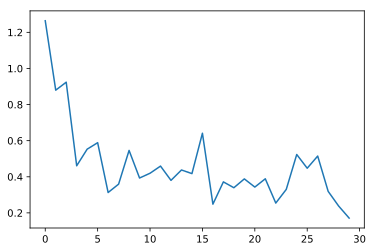

In [7]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})

W = Variable(torch.DoubleTensor(size=(num_inputs, num_outputs)).uniform_(), requires_grad=True)
b = Variable(torch.DoubleTensor(num_outputs).uniform_(), requires_grad=True)

pause = '\n'
epochs = 30
learning_rate = 1e-02
losses = []

for epoch in range(epochs):
    for index, (data, labels) in enumerate(train_loader):
        X = data.contiguous().view(batch_size, num_inputs).double()
        y = one_hot_embedding(labels).double()
        z = softmax(X)
        l = cross_entropy(y, z)
        l.backward()
        W.data = W.data - learning_rate * W.grad.data
        W.grad.data.zero_()
        b.data = b.data - learning_rate * b.grad.data
        b.grad.data.zero_()
    numerical_loss = l.detach().numpy()
    print('loss on epoch ', epoch, ': ', numerical_loss)
    losses.append(numerical_loss)
    
plt.plot(losses);

## accuracy

In [12]:
def accuracy(y, z):
    return (z.argmax(dim=1) == y.argmax(dim=1)).float().mean()

In [9]:
z_train = softmax(train_dataset.train_data.view(60000, 28*28).double())
y_train = one_hot_embedding(train_dataset.train_labels).double()
print('train accuracy: ', accuracy(y_train, z_train).detach().numpy())

train accuracy:  0.8826


In [10]:
z_test = softmax(test_dataset.test_data.view(10000, 28*28).double())
y_test = one_hot_embedding(test_dataset.test_labels).double()
print('test accuracy: ', accuracy(y_test, z_test).detach().numpy())

test accuracy:  0.8884


***

		 label:  0


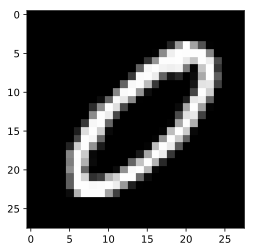

		 (28, 28) px


,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ix = np.random.randint(10000)
print('\t\t', 'label: ', test_dataset.test_labels[ix].item())
image = test_dataset.test_data[ix]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('\t\t', image.shape, 'px')

ixs = test_loader.dataset.test_data[ix].view(1, num_inputs).double()
s = (softmax(ixs)*10).int().float()/10
pd.DataFrame(s.numpy())

In [49]:
print(metrics.confusion_matrix(test_dataset.test_labels.detach(), np.argmax(z_test.detach(), axis=1)))

[[ 958    0    1    4    0    1    6    1    9    0]
 [   0 1076    3    3    0    0    4    2   47    0]
 [  12    5  870   23   15    0   13   20   68    6]
 [   7    1   15  889    0   20    6   10   55    7]
 [   2    1    5    1  869    0   14    3   30   57]
 [  16    3    4   64   11  618   18   10  139    9]
 [  13    2    6    4   13    7  900    3   10    0]
 [   4    6   25   12    5    0    1  926    9   40]
 [  12    3    5   14    6    5    8    9  906    6]
 [  11    4    3    8   39    2    0   34   36  872]]


In [46]:
print(metrics.classification_report(test_dataset.test_labels.detach(), np.argmax(z_test.detach(), axis=1)))

             precision    recall  f1-score   support

          0       0.93      0.98      0.95       980
          1       0.98      0.95      0.96      1135
          2       0.93      0.84      0.88      1032
          3       0.87      0.88      0.88      1010
          4       0.91      0.88      0.90       982
          5       0.95      0.69      0.80       892
          6       0.93      0.94      0.93       958
          7       0.91      0.90      0.91      1028
          8       0.69      0.93      0.79       974
          9       0.87      0.86      0.87      1009

avg / total       0.90      0.89      0.89     10000

